<a href="https://colab.research.google.com/github/mikimowski/Machine-Learning/blob/master/MiniTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from abc import ABC, abstractmethod
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
from sklearn.model_selection import train_test_split
import torch

plt.rcParams["figure.figsize"] = (13,8)

# MiniTorch

Simplified, from scratch, implementation of essential modules from Torch library.

In [ ]:
Tensor = np.ndarray

#### Parameter

In [ ]:
class Parameter:
    def __init__(self, data: Tensor):
        self.data = data
        self._grad = np.zeros_like(data)

    def zero_grad(self):
        self._grad = np.zeros_like(self.data)

    @property
    def grad(self) -> Tensor:
        return self._grad

    @grad.setter
    def grad(self, grad: Tensor):
        assert self.data.shape == grad.shape
        self._grad = grad

    def __repr__(self):
        return 'Parameter containing:\n' + str(self.data)

#### Module

In [ ]:
class Module(ABC):
    def __init__(self):
        self._train_mode = True

    @abstractmethod
    def forward(self, X: Tensor) -> Tensor:
        pass
    
    @abstractmethod
    def backward(self, X: Tensor) -> Tensor:
        pass

    @abstractmethod
    def zero_grad(self):
        pass

    def params(self) -> Parameter:
        return None

    def n_params(self) -> int:
        return 0

    def train(self):
        self._train_mode = True

    def eval(self):
        self._train_mode = False

## Utils

In [ ]:
def get_params_norm(params, norm='L2', reduction='mean'):
    if norm == 'L2':
        res = np.sum([np.sum(param.data ** 2) for param in params])
        if reduction == 'mean':
            n_params = np.sum([np.prod(param.data.shape) for param in params])
            res /= n_params
        return res
    else:
        raise NotImplemented

def get_params_stats(params, norm='L2', reduction='mean'):
    total_norm, maxx, minn, n_params = 0, float("-inf"), float("inf"), 0
    if norm == 'L2':
        for param in params:
            param_norm = param.data ** 2
            total_norm += np.sum(param_norm)
            maxx = max(maxx, np.max(param_norm))
            minn = min(minn, np.min(param_norm))
            n_params += np.prod(param.data.shape)
        if reduction == 'mean':
            total_norm /= n_params
        return total_norm, maxx, minn
    else:
        raise NotImplemented

## Activations

#### Functional

In [ ]:
def sigmoid(x, derivative=False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1.0 / (1.0 + np.exp(-x))

def id(x, derivative=False):
    if derivative:
        return 1
    return x

def softmax(z, derivative=False):
    """ Takes as input raw vector of numbers and returns normalized vector representing
    valid probability disitribution.
    softmax: R^n -> R^n

    Args:
        z: (batch_size, n_inputs)
    """
    exp = np.exp(z)
    s = exp / (np.sum(exp, axis=1, keepdims=True)) # keepdims is crucial !
    # # Iterative implementation
    # if derivative:
    #     jacobian = np.zeros((z.shape[0], z.shape[1], z.shape[1]))
    #     for i in range(z.shape[0]): # for each sample
    #         # for each pair of features
    #         # alternatively: np.diagflat(s[i]) + np.dot(-s[i], s[i].T)  
    #         for k in range(z.shape[1]):
    #             for l in range(z.shape[1]):
    #                 if k == l:
    #                     jacobian[i,k,l] = s[i,k] - s[i,k]**2
    #                 else:
    #                     jacobian[i,k,l] = -s[i,k] * s[i,l]
    #     return jacobian
    if derivative:
        """
        https://stackoverflow.com/questions/40575841/numpy-calculate-the-derivative-of-the-softmax-function
        https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
        Jacobian:
        [s1*(1-s1); -s1*s2   ; -s1*s3   ]
        [-s2*s1   ; s2*(1-s2); -s2*s3   ]
        [-s3*s1   ; -s3*s2   ; s3*(1-s3)]
            =
        [s1; 0 ; 0 ]     [-s1*s1; -s1*s2; -s1*s3]
        [0 ; s2; 0 ]  +  [-s2*s1; -s2*s2; -s2*s3]
        [0 ; 0 ; s3]     [-s3*s1; -s3*s2; -s3*s3]
        """
        # diag = np.diagflat(z.shape[1]) * s
        # `s` shape: (batch_size, n_inputs)
        # `jacobian` shape: (batch_size, n_inputs, n_inputs)
        # If there was no batches: jacobian = np.diagflat(s) + np.dot(-s, s.T)
        # But since we are processing examples in batches we need sth more sophisticated
        s1 = np.einsum('ij,jk->ijk', s, np.eye(s.shape[-1]))
        s2 = np.einsum('ij,ik->ijk', -s, s)
        jacobian = s1 + s2
        assert jacobian.shape == (z.shape[0], z.shape[1], z.shape[1])
        return jacobian
    else:
        assert s.shape == z.shape
        return s

### Modular

#### Sigmoid

In [ ]:
class Sigmoid(Module):
    def forward(self, X: Tensor) -> Tensor:
        if self._train_mode:
            self._cache = {'X': X}
        return sigmoid(X)
    
    def __call__(self, X: Tensor) -> Tensor:
        return self.forward(X)

    def backward(self, Y: Tensor) -> Tensor:
        return Y * sigmoid(self._cache['X'], derivative=True)
    
    def zero_grad(self):
        """ Clear cache """
        self._cache = None

    def __str__(self):
        return f"Sigmoid()"

#### Softmax

In [ ]:
class Softmax(Module):
    """ Takes as input raw vector of numbers and returns normalized vector representing
        valid probability disitribution.
        softmax: R^n -> R^n

        Args:
            z: (batch_size, n_inputs)
    """
    def forward(self, X: Tensor) -> Tensor:
        exp = np.exp(X)
        S = exp / (np.sum(exp, axis=1, keepdims=True)) # keepdims is crucial !
        assert S.shape == X.shape
        if self._train_mode:
            self._cache = {
                'X': X,
                'S': S
            }
        return S

    def __call__(self, X: Tensor) -> Tensor:
        return self.forward(X)
            
    def backward(self, Y: Tensor) -> Tensor:
        """
        https://stackoverflow.com/questions/40575841/numpy-calculate-the-derivative-of-the-softmax-function
        https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
        Jacobian:
        [s1*(1-s1); -s1*s2   ; -s1*s3   ]
        [-s2*s1   ; s2*(1-s2); -s2*s3   ]
        [-s3*s1   ; -s3*s2   ; s3*(1-s3)]
            =
        [s1; 0 ; 0 ]     [-s1*s1; -s1*s2; -s1*s3]
        [0 ; s2; 0 ]  +  [-s2*s1; -s2*s2; -s2*s3]
        [0 ; 0 ; s3]     [-s3*s1; -s3*s2; -s3*s3]
        """
        # # Iterative implementation
        # if derivative:
        #     jacobian = np.zeros((z.shape[0], z.shape[1], z.shape[1]))
        #     for i in range(z.shape[0]): # for each sample
        #         # for each pair of features
        #         # alternatively: np.diagflat(s[i]) + np.dot(-s[i], s[i].T)  
        #         for k in range(z.shape[1]):
        #             for l in range(z.shape[1]):
        #                 if k == l:
        #                     jacobian[i,k,l] = s[i,k] - s[i,k]**2
        #                 else:
        #                     jacobian[i,k,l] = -s[i,k] * s[i,l]
        #     return jacobian
       
        # `s` shape: (batch_size, n_inputs)
        # `jacobian` shape: (batch_size, n_inputs, n_inputs)
        # If there was no batches: jacobian = np.diagflat(s) + np.dot(-s, s.T)
        # But since we are processing examples in batches we need sth more sophisticated
        # print(z.shape, s.shape)
        # exp = np.exp(z)
        # S = exp / (np.sum(exp, axis=1, keepdims=True))
        S1 = np.einsum('ij,jk->ijk', self._cache['S'], np.eye(self._cache['S'].shape[-1]))
        S2 = np.einsum('ij,ik->ijk', -self._cache['S'], self._cache['S'])
        # Jacobian is `local_grad`
        jacobian = S1 + S2
        assert jacobian.shape == (self._cache['X'].shape[0], self._cache['X'].shape[1], self._cache['X'].shape[1])
        grad = np.zeros_like(self._cache['X'])
        # self.grads[f'dZ{layer}'] = np.zeros_like(self.cache[f'Z{layer}'])
        # jacobian = self.activations[layer](self.cache[f'Z{layer}'], derivative=True)
        # for each sample (not vectorized)
        for i in range(jacobian.shape[0]):
            # The dot product is between vector and matrix, so "all the paths by which z_i"
            # contributes to loss are summed up.
            # self.grads[i,:] = [dL/df1, dL/df2]
            # jacobian[i,:,:] = [df1/dz1, df1/dz2,
            #                    df2/dz1, df2/dz2]
            grad[i] += np.dot(Y[i,:], jacobian[i,:,:])
        return grad

    def zero_grad(self):
        """ Clear cache """
        self._cache = None

    def __str__(self):
        return f"Softmax()"

In [ ]:
class ReLU(Module):
    def forward(self, X: Tensor) -> Tensor:
        self._cache = { 'X': X }
        return np.maximum(0, X)

    def __call__(self, X: Tensor) -> Tensor:
        return self.forward(X)
            
    def backward(self, Y: Tensor) -> Tensor:
        return (self._cache['X'] > 0).astype(int)

    def zero_grad(self):
        """ Clear cache """
        self._cache = None

    def __str__(self):
        return f"ReLU()"


## Blocks

### Linear

In [ ]:
class Linear(Module):
    def __init__(self, in_features: int, out_features: int):
        super(Linear, self).__init__()
        k = 1. / in_features
        self.weight = Parameter(np.random.uniform(-k, k, (out_features, in_features)))
    
    def forward(self, A: Tensor) -> Tensor:
        """ 
        Args:
            A - activation from the previous layer """
        if self._train_mode:
            self._cache = {'A': A}
        Z = np.dot(self.weight.data, A.T)
        return Z.T

    def __call__(self, A: Tensor) -> Tensor:
        return self.forward(A)

    def backward(self, Y: Tensor) -> Tensor:
        """ Populates grad 
        
        Return: Backpropagated gradient dY/dA
        """
        batch_size = self._cache['A'].shape[0]
        self.weight.grad = np.dot(Y.T, self._cache['A']) / batch_size
        self._cache = None
        return np.dot(Y, self.weight.data)

    def zero_grad(self):
        self.weight.zero_grad()

    def params(self):
        return self.weight
    
    def n_params(self):
        return np.prod(self.weight.data.shape)

    def train(self):
        self._train_mode = True

    def eval(self):
        self._train_mode = False       

    def __str__(self):
        return f"Linear {tuple(reversed(self.weight.data.shape))}"

In [ ]:
# Playground
l = Linear(3, 4)
X = np.arange(1, 7).reshape(2, 3)
print(X)
Y = l(X)
print(Y)
l.backward(Y)
print(l.weight.grad)

[[1 2 3]
 [4 5 6]]
[[ 0.85318418 -1.08250607 -0.63524891  0.5553514 ]
 [ 1.29891439 -2.6400559  -1.93642647  1.59672118]]
[[ 3.02442086  4.10047015  5.17651943]
 [-5.82136484 -7.68264583 -9.54392681]
 [-4.1904774  -5.47631509 -6.76215278]
 [ 3.47111805  4.54715434  5.62319063]]


### Sequential

In [ ]:
class Sequential(Module):
    def __init__(self, modules):
        super(Sequential, self).__init__()
        self.modules = modules
    
    def __call__(self, A: Tensor) -> Tensor:
        return self.forward(A)

    def forward(self, A: Tensor) -> Tensor:
        for module in self.modules:
            A = module(A)
        return A
            
    def backward(self, Y: Tensor):
        for module in reversed(self.modules):
            Y = module.backward(Y)
        return Y
    
    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()
        
    def params(self):
        return [module.params() for module in self.modules if module.params()]

    def n_params(self):
        return np.sum([module.n_params() for module in self.modules])

    def train(self):
        for module in self.modules:
            module.train()

    def eval(self):
        for module in self.modules:
            module.eval()
 
    def __str__(self):
        descr = "Sequential ("
        for module in self.modules:
            descr += f"\n    {module.__str__()},"
        return descr + "\n)" + f"\nTotal parameters: {self.n_params()}"
        # return descr + f"\n)\nTotal parameters: {self.n_params()}"

In [ ]:
# Playground
l = Linear(3, 4)
X = np.arange(1, 7).reshape(2, 3)
s = Sequential([Linear(3, 4), Linear(4, 5), Linear(5, 6), Sigmoid()])
Y = s(X)
print(Y)
print(s.backward(Y))

[[0.49726952 0.49935347 0.50527792 0.49281265 0.50071422 0.4977992 ]
 [0.47330543 0.498388   0.50776901 0.48119626 0.51280699 0.48012228]]
[[-8.18329376e-03  3.19726316e-05  1.60863669e-03]
 [-7.68859898e-03  4.72329873e-05  1.50660131e-03]]


In [ ]:
l = Linear(3, 4)
X = np.arange(1, 7).reshape(2, 3)
s = Sequential([Linear(3, 4), Linear(4, 5), Softmax()])
Y = s(X)
print(Y)
print(s.backward(Y))

[[0.19404437 0.15648562 0.19307969 0.21654666 0.23984366]
 [0.17299591 0.10012981 0.21788144 0.20342123 0.30557161]]
[[0.0003364  0.00078611 0.00060922]
 [0.00162468 0.00186663 0.00075223]]


### Tests

In [ ]:
def check_grad_linear(h=1e-6):
    batch_size = 8
    layer = Linear(3, 4)
    X = np.random.rand(batch_size, 3)
    Z = layer(X)
    dZ_dX = layer.backward(np.ones_like(Z))
    Z = np.sum(Z)
    for dim1 in range(X.shape[0]):
        for dim2 in range(X.shape[1]):
            X[dim1, dim2] += h
            Z_dist = layer(X)
            Z_dist = np.sum(Z_dist)
            dw_numerical = (Z_dist - Z) / h
            X[dim1, dim2] -= h
            assert np.allclose(dZ_dX[dim1, dim2], dw_numerical)

    dZ_dW = layer.weight.grad
    for dim1 in range(layer.weight.data.shape[0]):
        for dim2 in range(layer.weight.data.shape[1]):
            layer.weight.data[dim1, dim2] += h
            Z_dist = layer(X)
            Z_dist = np.sum(Z_dist)
            dw_numerical = (Z_dist - Z) / h
            dw_numerical /= batch_size
            layer.weight.data[dim1, dim2] -= h
            assert np.allclose(dZ_dW[dim1, dim2], dw_numerical)

check_grad_linear()

In [ ]:
def check_grad_sequential_linear(h=1e-6):
    layer = Sequential([Linear(3, 4), Linear(4, 5)])
    
    batch_size = 8
    X = np.random.rand(batch_size, 3)
    Z = layer(X)
    dZ_dX = layer.backward(np.ones_like(Z))
    Z = np.sum(Z)
    for dim1 in range(X.shape[0]):
        for dim2 in range(X.shape[1]):
            X[dim1, dim2] += h
            Z_dist = layer(X)
            Z_dist = np.sum(Z_dist)
            dw_numerical = (Z_dist - Z) / h
            X[dim1, dim2] -= h
            assert np.allclose(dZ_dX[dim1, dim2], dw_numerical)

    for module in layer.modules:
        dZ_dW = module.weight.grad
        for dim1 in range(module.weight.data.shape[0]):
            for dim2 in range(module.weight.data.shape[1]):
                module.weight.data[dim1, dim2] += h
                Z_dist = layer(X)
                Z_dist = np.sum(Z_dist)
                dw_numerical = (Z_dist - Z) / h
                dw_numerical /= batch_size
                module.weight.data[dim1, dim2] -= h
                # print(dZ_dW[dim1, dim2], dw_numerical)
                assert np.allclose(dZ_dW[dim1, dim2], dw_numerical)

check_grad_sequential_linear()

In [ ]:
def check_grad_sequential_complex(h=1e-6):
    layer = Sequential([Linear(3, 4), Sigmoid(), Linear(4, 5), Softmax()])
    
    batch_size = 8
    X = np.random.rand(batch_size, 3)
    Z = layer(X)
    dZ_dX = layer.backward(np.ones_like(Z))
    Z = np.sum(Z)
    for dim1 in range(X.shape[0]):
        for dim2 in range(X.shape[1]):
            X[dim1, dim2] += h
            Z_dist = layer(X)
            Z_dist = np.sum(Z_dist)
            dw_numerical = (Z_dist - Z) / h
            X[dim1, dim2] -= h
            assert np.allclose(dZ_dX[dim1, dim2], dw_numerical)

    for module in layer.modules:
        if hasattr(module, 'weight'):
            dZ_dW = module.weight.grad
            for dim1 in range(module.weight.data.shape[0]):
                for dim2 in range(module.weight.data.shape[1]):
                    module.weight.data[dim1, dim2] += h
                    Z_dist = layer(X)
                    Z_dist = np.sum(Z_dist)
                    dw_numerical = (Z_dist - Z) / h
                    dw_numerical /= batch_size
                    module.weight.data[dim1, dim2] -= h
                    assert np.allclose(dZ_dW[dim1, dim2], dw_numerical)

check_grad_sequential_complex()

## Loss functions

In [ ]:
class Loss:
    @abstractmethod
    def loss(self, input, target):
        raise NotImplemented

    @abstractmethod
    def grad(self, input, target):
        """dLoss(input, target) / dInput """
        raise NotImplemented

### MSE

In [ ]:
class MSE(Loss):
    def loss(self, input, target, reduction=None):
        loss = np.sum((target - input) ** 2)
        # Reduction across batch_size
        if reduction == 'mean':
            loss *= 1/target.shape[0]
        return loss

    def __call__(self, *args):
        return self.loss(*args)
    
    def grad(self, input, target, reduction=None):
        dSquare = 2 * (target - input)
        dInput = -(dSquare).astype(np.float)
        assert dInput.shape == input.shape
        if reduction == 'mean':
            dInput *= 1/target.shape[0]
        return dInput

### NLLLoss

In [ ]:
class NLLLoss(Loss):
    """ Calculates Negative Log Likelihood loss.

    Expected probs values, thus `input` should be passed via Softmax Layer.
    
    input:  (batch_size, n_classes) <- probs
    target: (batch_size, n_classes) <- one_hot encoding
    """
    def loss(self, input, target, reduction=None):
        loss = -np.sum(target * np.log(input))
        if reduction == 'mean':
            loss /= target.shape[0]   
        return loss
    
    def __call__(self, *args):
        return self.loss(*args)

    def grad(self, input, target, reduction=None):
        grad = np.zeros_like(input)
        index = np.argmax(target, axis=1).reshape(-1, 1)
        np.put_along_axis(grad, index, -1 / np.take_along_axis(input, index, axis=1), axis=1)
        if reduction == 'mean':
            grad /= target.shape[0]
        return grad

### CrossEntropy

In [ ]:
class CrossEntropy(Loss):
    """ Calculates CrossEntropy loss. 
    
    Expects raw logits, thus `input` should not be passed via Softmax layer.

    input:  (batch_size, n_classes) <- raw logits
    target: (batch_size, n_classes) <- one_hot encoding
    """
    def loss(self, input, target, reduction=None):
        input = softmax(input)
        loss = -np.sum(target * np.log(input))
        if reduction == 'mean':
            loss /= target.shape[0]   
        return loss

    def __call__(self, *args):
        return self.loss(*args)

    def grad(self, input, target, reduction=None):
        grad = softmax(input) - target
        if reduction == 'mean':
            grad /= target.shape[0]   
        return grad

### HingeLoss

In [ ]:

class HingeLoss(Loss):
    def __init__(self, margin: float = 0.0001):
        self._margin = margin

    def loss(self, input, target, reduction=None):
        correct_index = np.argmax(target, axis=1).reshape(-1, 1)
        # exactly one entry - of the correct class - will be 0
        incorrect_targets_mask = (1 - target)
        diff = input - np.take_along_axis(input, correct_index, axis=1) + self._margin * incorrect_targets_mask
        loss = np.sum(np.maximum(0, diff))
        if reduction == 'mean':
            loss /= target.shape[0]   
        return loss

    def __call__(self, *args):
        return self.loss(*args)

    def grad(self, input, target, reduction=None):
        correct_index = np.argmax(target, axis=1).reshape(-1, 1)
        # exactly one entry - of the correct class - will be 0
        incorrect_targets_mask = (1 - target)
        diff = input - np.take_along_axis(input, correct_index, axis=1) + self._margin * incorrect_targets_mask
        grad = (diff > 0).astype(float)
        np.put_along_axis(
            grad,
            correct_index,
            np.expand_dims(-(np.sum(grad, axis=1)), -1),
            axis=1,
        )
        if reduction == 'mean':
            grad /= target.shape[0]   
        return grad

#### Tests

In [ ]:
def check_grad_loss(loss, h=1e-8):
    batch_size, n_classes = 20, 10
    input = np.random.rand(batch_size, n_classes)
    index = np.random.randint(0, n_classes, size=(batch_size,1))
    target = np.zeros((batch_size, n_classes))
    np.put_along_axis(target, index, 1, axis=1)
    out = loss(input, target)
    grad = loss.grad(input, target)
    for dim1 in range(input.shape[0]):
        for dim2 in range(input.shape[1]):
            input[dim1, dim2] += h
            out_dist = loss(input, target)
            dw_numerical = (out_dist - out) / h
            input[dim1, dim2] -= h
            # print(grad, grad[dim1, dim2], dw_numerical)
            # print(abs(grad[dim1, dim2] - dw_numerical))
            # print(grad[dim1, dim2] - dw_numerical)
            assert abs(grad[dim1, dim2] - dw_numerical) < 1e-4

In [ ]:
check_grad_loss(MSE())

In [ ]:
check_grad_loss(NLLLoss())

In [ ]:
check_grad_loss(CrossEntropy())

In [ ]:
check_grad_loss(HingeLoss())

# Optim

In [ ]:
class Optim:
    def __init__(self, params, lr, weight_decay=0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay

    @abstractmethod
    def step(self, **kwargs):
        raise NotImplemented

    def _weight_penalty_grad(self, param):
        if self.weight_decay > 0:
            return self.weight_decay * 2 * param.data
        else:
            return 0

### SGD

In [ ]:
class SGD(Optim):
    def __init__(self, params, lr, weight_decay=0):
        super(SGD, self).__init__(params, lr, weight_decay)

    def step(self, **kwargs):
        for param in self.params:
            param.data -= self.lr * (param.grad + self._weight_penalty_grad(param))

### Momentum

In [ ]:
class Momentum(Optim):
    def __init__(self, params, lr, weight_decay=0., beta=0.9):
        super(Momentum, self).__init__(params, lr, weight_decay)
        self.beta = beta
        # Starting momentum for each param
        self.momentum = [np.zeros_like(param.data) for param in params]

    def step(self, **kwargs):
        for i, param in enumerate(self.params):
            self.momentum[i] = self.beta * self.momentum[i] + (param.grad + self._weight_penalty_grad(param))
            param.data -= self.lr * self.momentum[i]

### Adam

In [ ]:
class Adam(Optim):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.):
        super(Adam, self).__init__(params, lr, weight_decay)
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        # Starting moments for each param
        self.m = [np.zeros_like(param.data) for param in params]
        self.v = [np.zeros_like(param.data) for param in params]
        self.t = 0

    def step(self, **kwargs):
        self.t += 1
        for i, param in enumerate(self.params):
            weight_penalty_grad = self._weight_penalty_grad(param)
            self.m[i] = self.beta1 * self.m[i] + (1-self.beta1) * (param.grad + weight_penalty_grad)
            self.v[i] = self.beta2 * self.v[i] + (1-self.beta2) * ((param.grad + weight_penalty_grad) ** 2)
            mt = self.m[i] / (1-self.beta1**self.t)
            vt = self.v[i] / (1-self.beta2**self.t)
            param.data -= self.lr * mt / (np.sqrt(vt) + self.eps)

# DataLoader

In [ ]:
class Dataset:
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return (self.data[idx], self.targets[idx])

class DataLoader:
    def __init__(self, dataset, batch_size=32, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __iter__(self):
        self.offset = 0
        if self.shuffle:
            self.indices = np.random.permutation(len(self.dataset))
        else:
            self.indices = np.arange(len(self.dataset))
        return self

    def __next__(self):
        if self.offset >= len(self.dataset):
            raise StopIteration
        batch = self.dataset[self.offset: self.offset+self.batch_size]
        self.offset += self.batch_size
        return batch

# Data

In [ ]:
from torchvision import datasets, transforms

def flatten_features(x):
    return x.reshape(x.shape[0], -1)

def load_mnist(path='.', flatten=False):
    train_set = datasets.MNIST(path, train=True, download=True)
    x_train = train_set.data.numpy()
    _y_train = train_set.targets.numpy()
    
    test_set = datasets.MNIST(path, train=False, download=True)
    x_test = test_set.data.numpy()
    _y_test = test_set.targets.numpy()
    
    x_train = x_train / 255.
    x_test = x_test / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    if flatten:
        x_train, x_test = flatten_features(x_train), flatten_features(x_test)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist(flatten=True)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

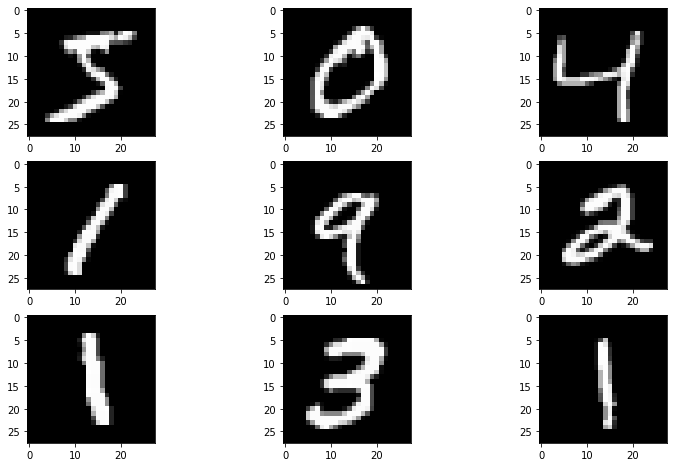

In [ ]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
def normalize(data, epsilon=1e-10):
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)
    data = (data - mean) / (std + epsilon)
    return data

def rescale(data):
    data = data / np.max(data)
    return data

In [ ]:
train_dataset = Dataset(x_train, y_train)
test_dataset = Dataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

# Training pipeline

In [ ]:
def get_correct(outs, targets):
    return np.sum(np.argmax(targets, axis=1) == np.argmax(outs, axis=1))

def evaluate(net, test_loader):
    net.eval()
    correct, N = 0, 0
    for x_batch, y_batch in test_loader:
        outs = net(x_batch)
        correct += get_correct(outs, y_batch)
        N += y_batch.shape[0]
    return correct / N

In [ ]:
def train(net, optim, loss_fn, n_epochs, train_loader, test_loader=None, log_interval=10):
    losses, train_acc, test_acc = [], [], [] if test_loader else None
    net.train()
    for epoch in range(n_epochs):
        epoch_loss, epoch_samples, epoch_correct = 0, 0, 0
            
        for x_batch, y_batch in train_loader:
            net.zero_grad()
            outs = net(x_batch)
            epoch_correct += get_correct(outs, y_batch)
            loss = loss_fn.loss(outs, y_batch, reduction=None)
            loss_grad = loss_fn.grad(outs, y_batch, reduction=None)
            net.backward(loss_grad)
            optim.step()
            epoch_samples += y_batch.shape[0]
            epoch_loss += loss

        if test_loader:
            test_acc.append(evaluate(net, test_loader))
            net.train()
        losses.append(epoch_loss / epoch_samples)
        train_acc.append(epoch_correct / epoch_samples)

        if epoch % log_interval == 0:
            print(
                f"Epoch {epoch+1}: loss: {losses[-1]:.4}, train acc: {train_acc[-1]:.4}, test acc: {test_acc[-1]:.4}, "
            )
    print(
        f"Final epoch {n_epochs}: loss: {losses[-1]:.4}, train acc: {train_acc[-1]:.4}, test acc: {test_acc[-1]:.4}, "
    )
    return losses, train_acc, test_acc

In [ ]:
def plot_training(losses, train_acc, test_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle("Training progress")
    # loss
    ax1.set_title("loss")
    ax1.plot(losses)
    # acc
    epochs = list(range(len(losses)))
    ax2.set_title("accuracy")
    ax2.plot(epochs, train_acc, label="train acc")
    ax2.plot(epochs, test_acc, label="test acc")
    ax2.legend()

def plot_exps(exps):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6)) 
    fig.suptitle("Training")
    ax1.set_title("loss")
    ax2.set_title("train accuracy")
    ax3.set_title("test accuracy")

    for exp, (losses, train_acc, test_acc) in exps.items():
        epochs = list(range(len(losses)))
        ax1.plot(losses, label=exp)
        ax2.plot(epochs, train_acc, label=exp)
        ax3.plot(epochs, test_acc, label=exp)

    ax1.legend(loc="upper right") 
    ax2.legend(loc="lower right") 
    ax3.legend(loc="lower right")
    plt.show()

# Adversarial Attacks

In [ ]:
from collections import namedtuple

AdversarialExample = namedtuple('AdversarialExample', ['x', 'y', 'y_hat', 'prob', 'noise', 'x_adv', 'y_adv', 'prob_adv'])

def find_adversarial_example(net, x, y, is_softmax, loss_fn, eps):
    """ Finds adversarial example for given (x, y) """
    prob = net(x)
    if not is_softmax:
        prob = softmax(prob)
    x_grad = net.backward(loss_fn.grad(prob, y, reduction=None))
    noise = eps * np.sign(x_grad)
    x_adv = x + eps * np.sign(x_grad)
    prob_adv = net(x_adv)
    if not is_softmax:
        prob_adv = softmax(prob_adv)
    return AdversarialExample(x[0], np.argmax(y[0]), np.argmax(prob[0]), np.max(prob[0]), noise, 
                              x_adv[0], np.argmax(prob_adv[0]), np.max(prob_adv[0]))

def find_adversarial_examples(net, x_train, y_train, loss_fn=CrossEntropy(), eps=.07, is_softmax=True):
    """ Cherry picks worst case adversarial example """
    adversarial_examples = {}
    for x, y in zip(x_train, y_train):
        x, y = x.reshape(1, -1), y.reshape(1, -1)
        ae = find_adversarial_example(net, x, y, is_softmax, loss_fn, eps)
        # networks was not sure anyway or wrong 
        # or class is unchanged, so it's a poor adv example
        if ae.y_hat != ae.y or ae.prob < 0.95 or ae.y_adv == ae.y: 
            continue
        if ae.y not in adversarial_examples or ae.prob_adv > adversarial_examples[ae.y].prob_adv:
            adversarial_examples[ae.y] = ae
    return adversarial_examples

def present_adversarial_attack(adversarial_examples):
    assert len(adversarial_examples.keys()) == 10
    for adversarial_example in adversarial_examples.values():
        plot_adversarial_example(adversarial_example)

In [ ]:
def plot_adversarial_example(adversarial_example):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5)) 
    ax1.imshow(adversarial_example.x.reshape((28, 28)), cmap=plt.cm.binary)
    ax1.set_title(f"Actual example ({adversarial_example.prob * 100:.2f} for {adversarial_example.y})")
    ax2.imshow(adversarial_example.noise.reshape((28, 28)), cmap=plt.cm.binary) 
    ax2.set_title(f"Noise")
    ax3.imshow(adversarial_example.x_adv.reshape((28, 28)), cmap=plt.cm.binary) 
    ax3.set_title(f"Adversarial example ({adversarial_example.prob_adv * 100:.2f}% for {adversarial_example.y_adv})") 
    plt.show()

# Networks

Note: Training accuracy is calculated "on-the-fly" and averaged (to speed up computation). Test accuracy it calculated at the end of each epochs. Because MNIST is a very easy data set we can observe an anomaly of test acc > train acc.

Note 2: We will use deep networks from hw8, trained using Adam. In addition I will use one deeper MLP architecture as well.

In [ ]:
N_EPOCHS = 40
adversarial_examples = {}

## Deep

### DeepNN1(n, m1, m2, 10) 
Two hidden layer neural net with linear activations having input, 10 output neurons and m1 neurons in the first hidden layer, m2 neurons in the second hidden layer

Adam

Sequential (
    Linear (784, 100),
    Linear (100, 50),
    Linear (50, 10),
    Softmax(),
)
Total parameters: 83900
Epoch 1: loss: 1.515, train acc: 0.5409, test acc: 0.6946, 
Epoch 2: loss: 0.7706, train acc: 0.7493, test acc: 0.8062, 
Epoch 3: loss: 0.5786, train acc: 0.8279, test acc: 0.8518, 
Epoch 4: loss: 0.476, train acc: 0.8623, test acc: 0.8726, 
Epoch 5: loss: 0.4257, train acc: 0.8779, test acc: 0.8831, 
Epoch 6: loss: 0.3977, train acc: 0.8863, test acc: 0.8919, 
Epoch 7: loss: 0.3783, train acc: 0.8931, test acc: 0.898, 
Epoch 8: loss: 0.3648, train acc: 0.8969, test acc: 0.9005, 
Epoch 9: loss: 0.355, train acc: 0.8993, test acc: 0.9039, 
Epoch 10: loss: 0.3474, train acc: 0.9013, test acc: 0.905, 
Epoch 11: loss: 0.3413, train acc: 0.9034, test acc: 0.9069, 
Epoch 12: loss: 0.336, train acc: 0.9053, test acc: 0.9081, 
Epoch 13: loss: 0.3312, train acc: 0.9071, test acc: 0.909, 
Epoch 14: loss: 0.3266, train acc: 0.9086, test acc: 0.9093, 
Epoch 15: loss: 0.3221, trai

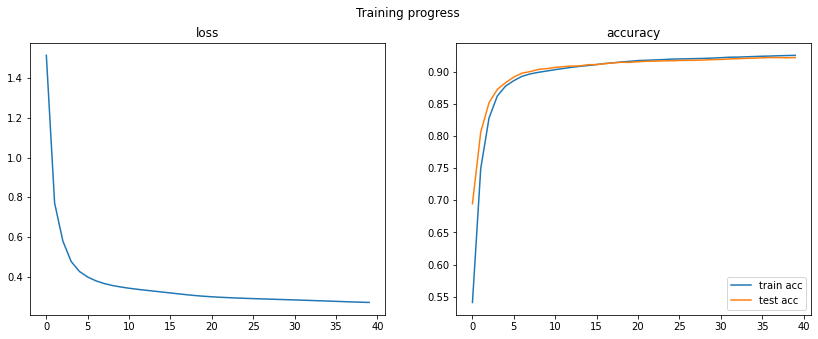

In [ ]:
net1 = Sequential([Linear(784, 100), Linear(100, 50), Linear(50, 10), Softmax()])

train_params = {
    'net': net1,
    'optim': Adam(net1.params(), lr=0.0001, weight_decay=0.0001),
    'loss_fn': NLLLoss(),
    'n_epochs': N_EPOCHS,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'log_interval': 1,
}

print(net1)
progress = train(**train_params)
plot_training(*progress)

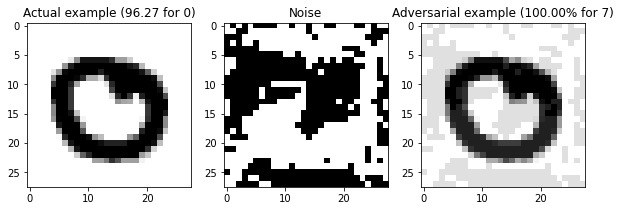

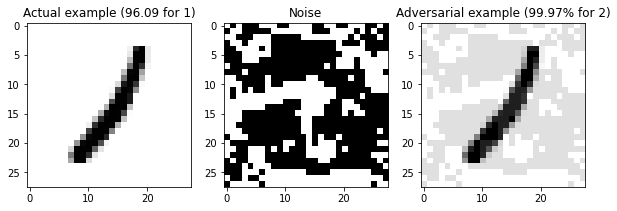

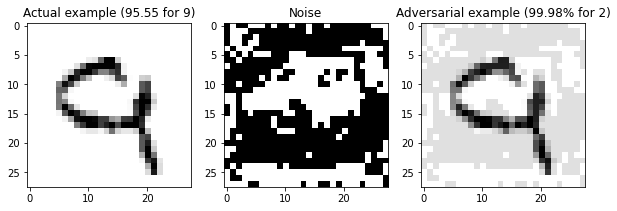

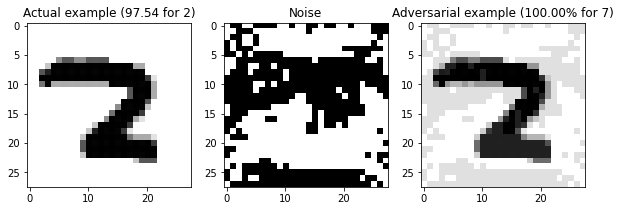

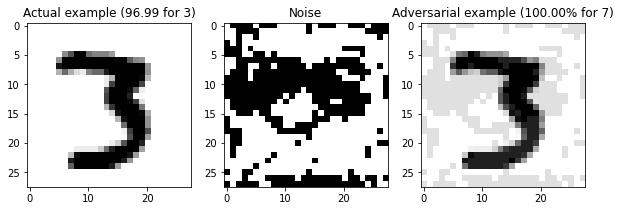

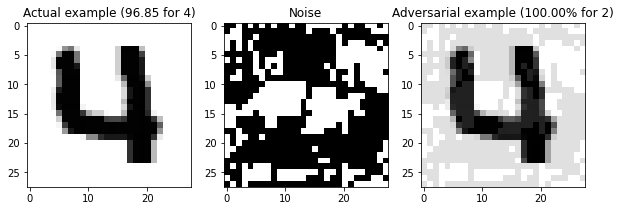

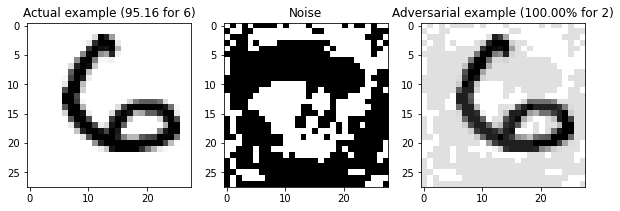

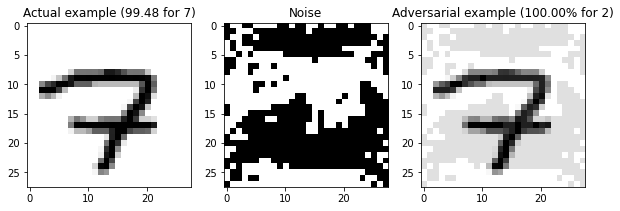

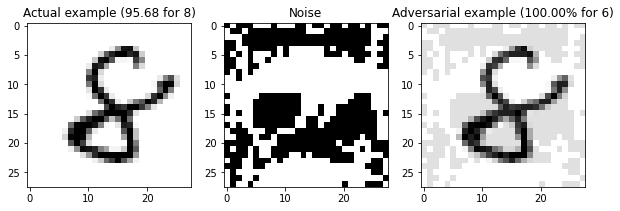

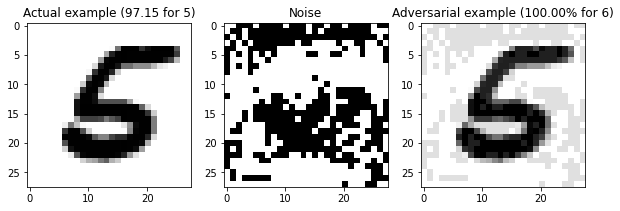

In [ ]:
adversarial_examples['net1'] = find_adversarial_examples(net1, x_train, y_train)
present_adversarial_attack(adversarial_examples['net1'])

### DeepNN2(n, m1, m2, 10) 
Two hidden layer neural net with sigmoidal activation function.

Adam

Sequential (
    Linear (784, 100),
    Sigmoid(),
    Linear (100, 50),
    Sigmoid(),
    Linear (50, 10),
    Softmax(),
)
Total parameters: 83900
Epoch 1: loss: 1.369, train acc: 0.5375, test acc: 0.7821, 
Epoch 2: loss: 0.5291, train acc: 0.8585, test acc: 0.9009, 
Epoch 3: loss: 0.3174, train acc: 0.9175, test acc: 0.9286, 
Epoch 4: loss: 0.2381, train acc: 0.9363, test acc: 0.943, 
Epoch 5: loss: 0.1981, train acc: 0.9458, test acc: 0.9475, 
Epoch 6: loss: 0.1727, train acc: 0.953, test acc: 0.9532, 
Epoch 7: loss: 0.1545, train acc: 0.9578, test acc: 0.9572, 
Epoch 8: loss: 0.1406, train acc: 0.9621, test acc: 0.9597, 
Epoch 9: loss: 0.1296, train acc: 0.9651, test acc: 0.9619, 
Epoch 10: loss: 0.1206, train acc: 0.9675, test acc: 0.9641, 
Epoch 11: loss: 0.1131, train acc: 0.9696, test acc: 0.9658, 
Epoch 12: loss: 0.1069, train acc: 0.9714, test acc: 0.9665, 
Epoch 13: loss: 0.1015, train acc: 0.9729, test acc: 0.9677, 
Epoch 14: loss: 0.09688, train acc: 0.9744, test acc: 0.

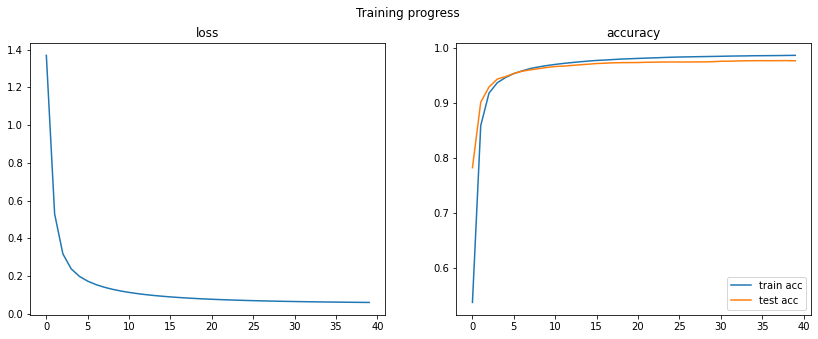

In [ ]:
net2 = Sequential([Linear(784, 100), Sigmoid(), 
                  Linear(100, 50), Sigmoid(), 
                  Linear(50, 10), 
                  Softmax()])

train_params = {
    'net': net2,
    'optim': Adam(net2.params(), 0.001, weight_decay=0.0001),
    'loss_fn': NLLLoss(),
    'n_epochs': N_EPOCHS,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'log_interval': 1,
}

print(net2)
progress = train(**train_params)
plot_training(*progress)

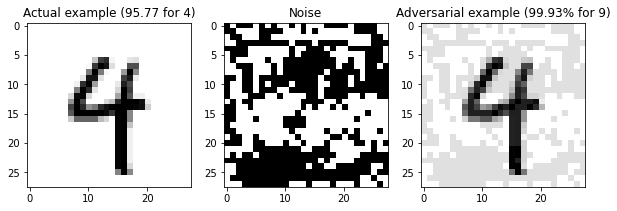

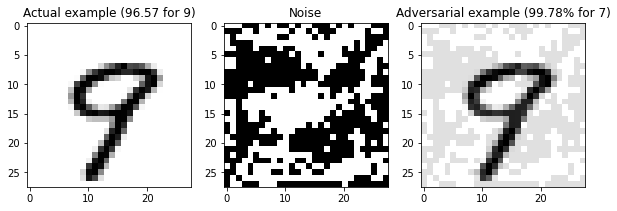

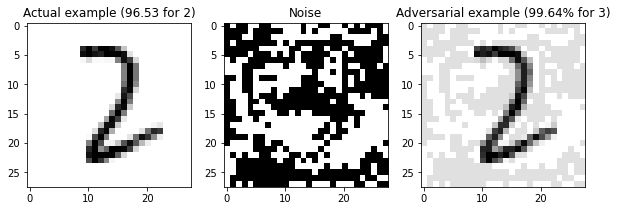

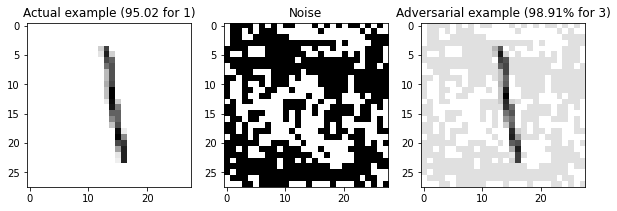

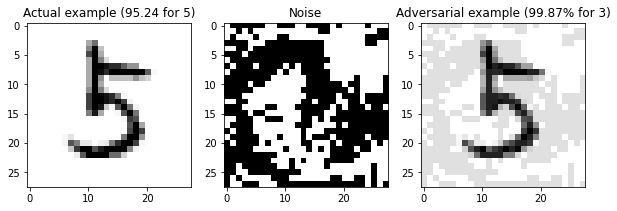

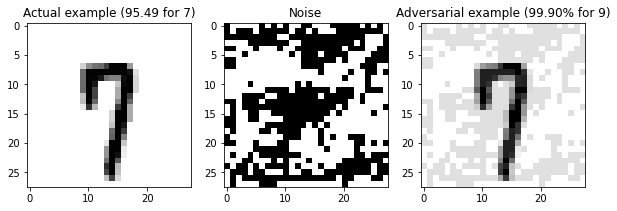

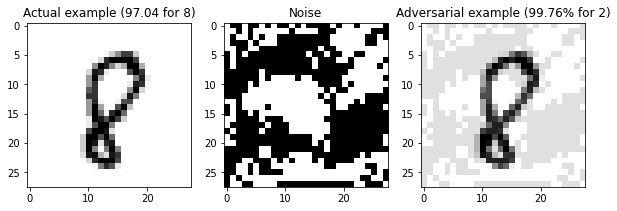

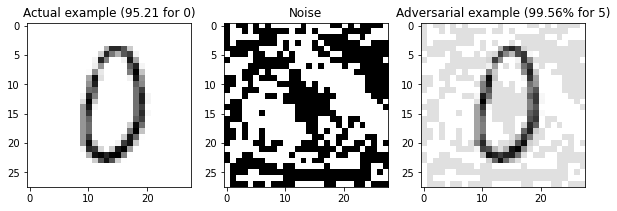

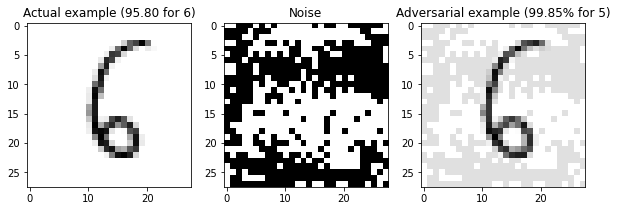

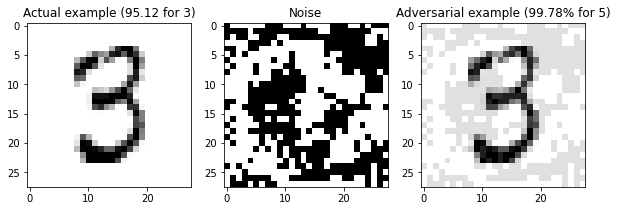

In [ ]:
adversarial_examples['net2'] = find_adversarial_examples(net2, x_train, y_train)
present_adversarial_attack(adversarial_examples['net2'])

# MLP

Sequential (
    Linear (784, 64),
    Sigmoid(),
    Linear (64, 64),
    Sigmoid(),
    Linear (64, 64),
    Sigmoid(),
    Linear (64, 64),
    Sigmoid(),
    Linear (64, 32),
    Sigmoid(),
    Linear (32, 32),
    Sigmoid(),
    Linear (32, 10),
)
Total parameters: 65856
Epoch 1: loss: 2.212, train acc: 0.111, test acc: 0.1956, 
Epoch 2: loss: 1.891, train acc: 0.203, test acc: 0.206, 
Epoch 3: loss: 1.84, train acc: 0.22, test acc: 0.2921, 
Epoch 4: loss: 1.292, train acc: 0.4839, test acc: 0.66, 
Epoch 5: loss: 0.7807, train acc: 0.7006, test acc: 0.7709, 
Epoch 6: loss: 0.5114, train acc: 0.8351, test acc: 0.8845, 
Epoch 7: loss: 0.3396, train acc: 0.9089, test acc: 0.8895, 
Epoch 8: loss: 0.2612, train acc: 0.9304, test acc: 0.9286, 
Epoch 9: loss: 0.2142, train acc: 0.9428, test acc: 0.94, 
Epoch 10: loss: 0.1857, train acc: 0.9501, test acc: 0.9427, 
Epoch 11: loss: 0.1716, train acc: 0.953, test acc: 0.9409, 
Epoch 12: loss: 0.1526, train acc: 0.9587, test acc: 0.9387, 
Epo

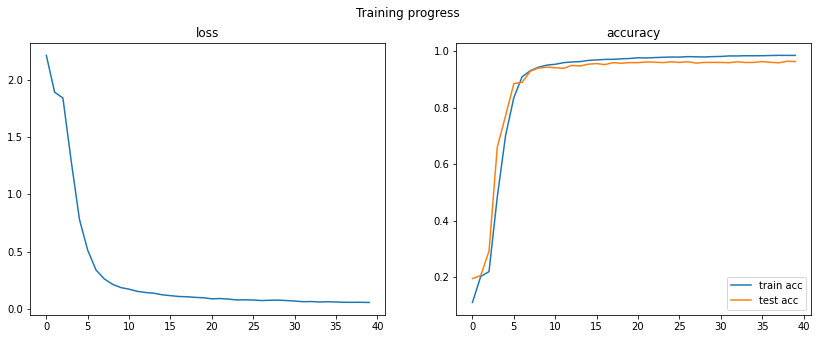

In [ ]:
np.random.seed(2021)

net3 = Sequential([Linear(784, 64), Sigmoid(), 
                  Linear(64, 64), Sigmoid(), 
                  Linear(64, 64), Sigmoid(), 
                  Linear(64, 64), Sigmoid(),
                  Linear(64, 32), Sigmoid(),
                  Linear(32, 32), Sigmoid(),
                  Linear(32, 10)])

train_params = {
    'net': net3,
    'optim': Adam(net3.params(), 0.01, weight_decay=0.),
    'loss_fn': CrossEntropy(),
    'n_epochs': N_EPOCHS,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'log_interval': 1,
}

print(net3)
progress = train(**train_params)
plot_training(*progress)

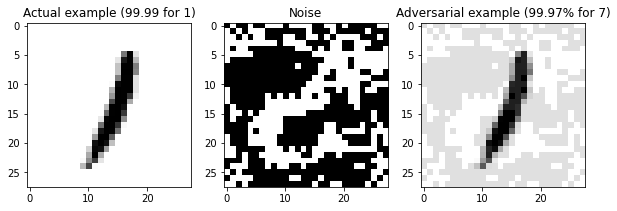

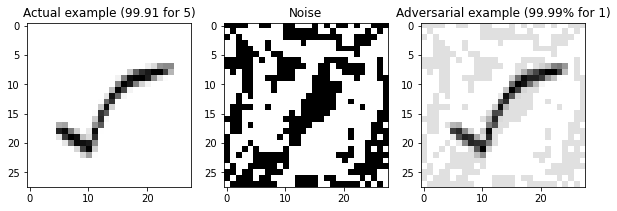

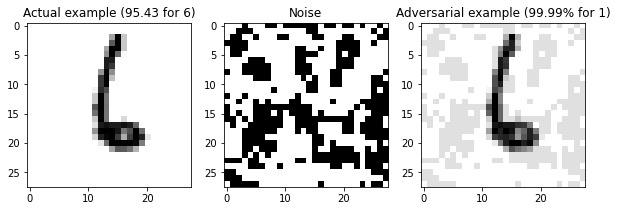

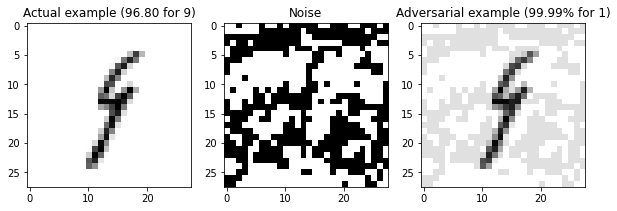

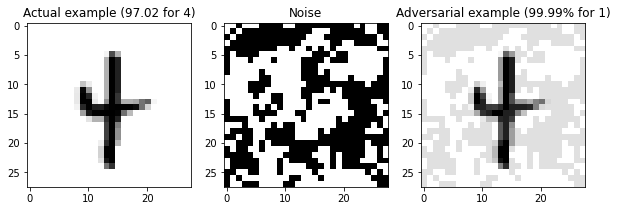

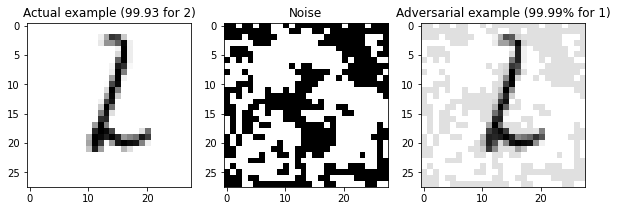

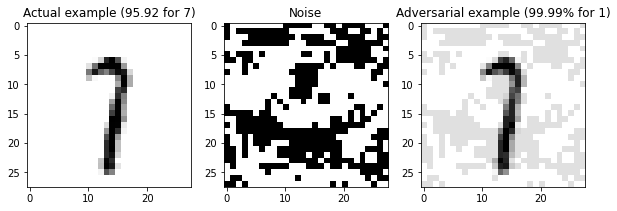

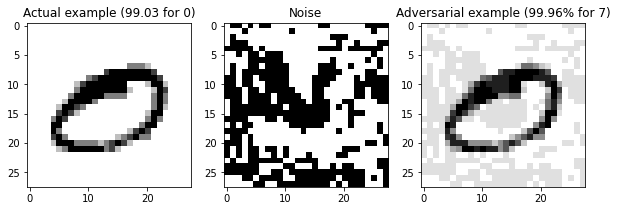

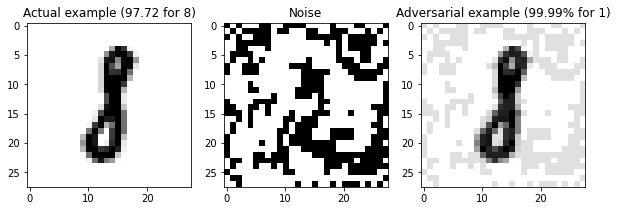

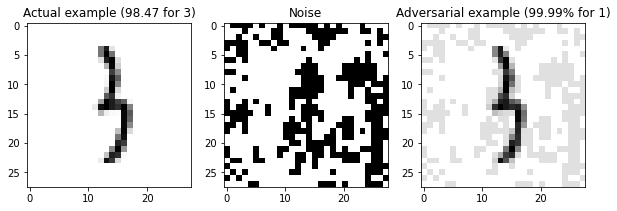

In [ ]:
adversarial_examples['net3'] = find_adversarial_examples(net3, x_train, y_train, is_softmax=False)
present_adversarial_attack(adversarial_examples['net3'])

## Bonus:

**Transfering adversarial examples**

In this part I will take adversarial examples for *net2* and compare how *net3* does on them, and the other way around.

Generally, we see that *net2* is less sure even about original examples - it's smaller and simpler, thus it makes sense, as it has smaller capacity.

On the other hand, *net3* has no issues with labeling original images.

Both models label adversarial examples incorrectly, but they are less confident about their choices.

In [ ]:
def preds_for_adv_exs(net, adversarial_examples, is_softmax=False):
    """ Extracts predictions of given network and transforms them into AdversarialExample schema """
    new_aes = {}
    for ae in adversarial_examples.values():
        prob = net(ae.x.reshape(1, -1))
        if not is_softmax:
            prob = softmax(prob)
        prob_adv = softmax(net(ae.x_adv.reshape(1, -1)))
        if not is_softmax:
            prob_adv = softmax(prob_adv)
        new_aes[ae.y] = AdversarialExample(ae.x, ae.y, np.argmax(prob[0]), np.max(prob[0]), ae.noise, 
                                           ae.x_adv, np.argmax(prob_adv[0]), np.max(prob_adv[0]))
    return new_aes

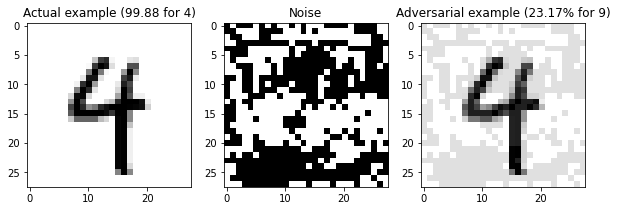

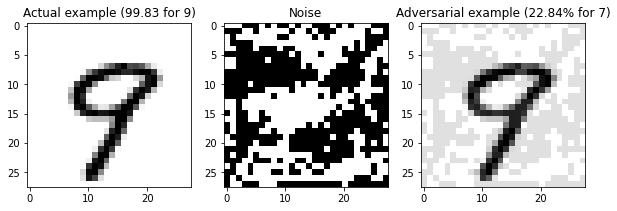

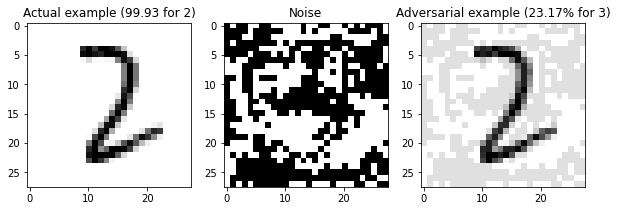

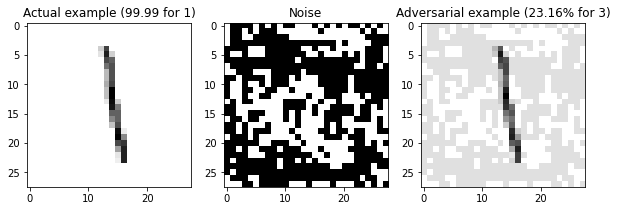

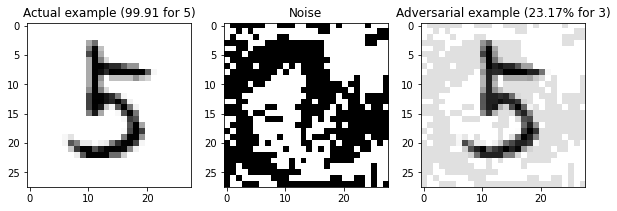

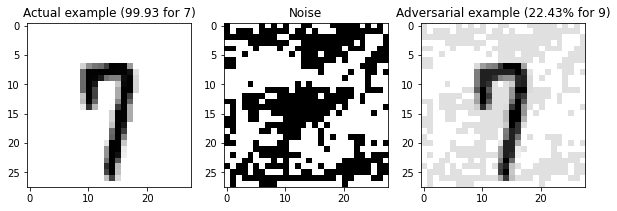

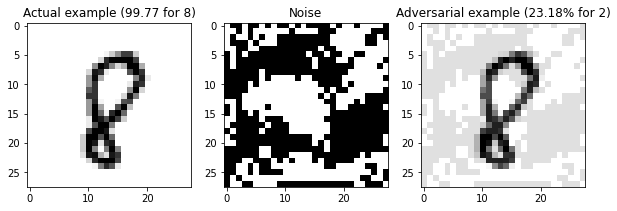

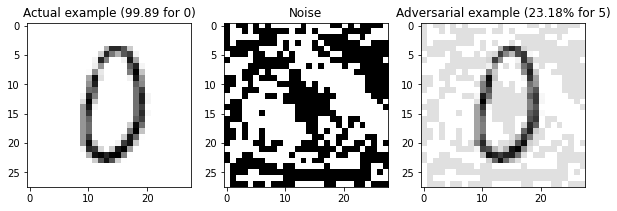

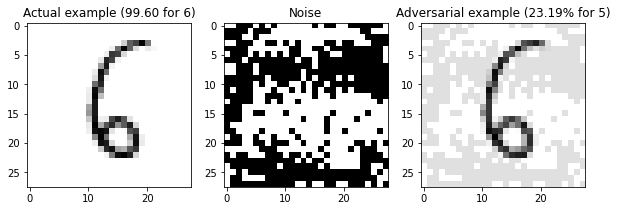

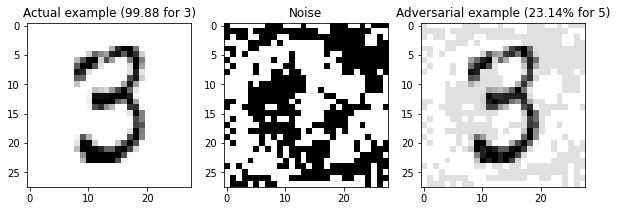

In [ ]:
present_adversarial_attack(preds_for_adv_exs(net3, adversarial_examples['net2'], is_softmax=False))

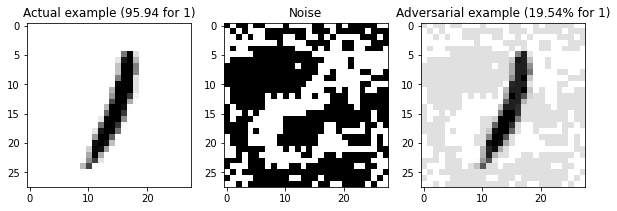

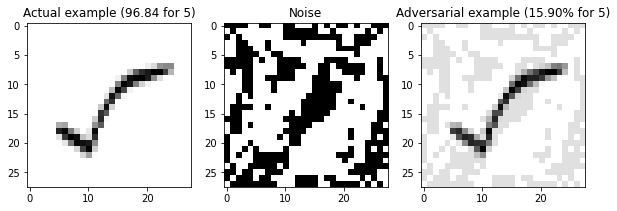

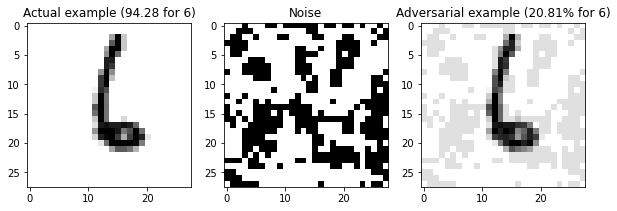

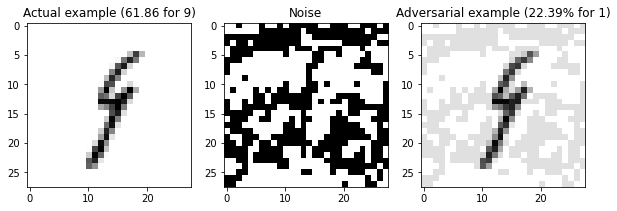

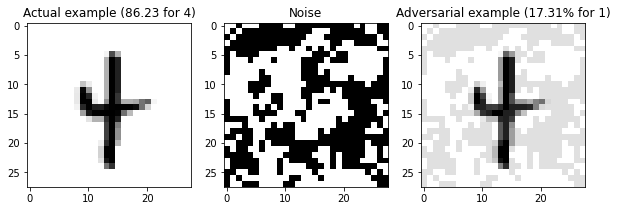

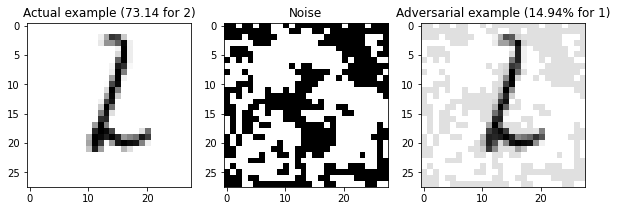

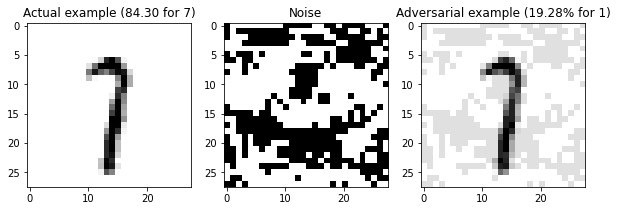

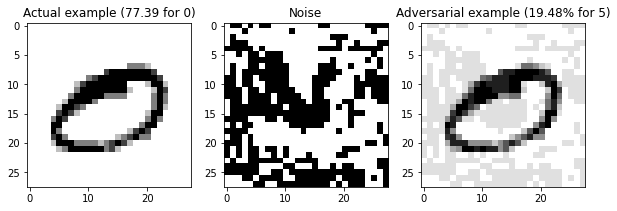

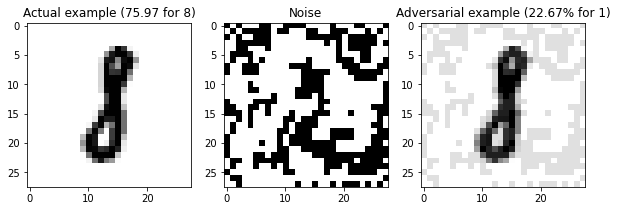

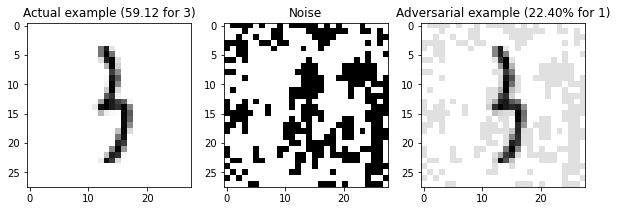

In [ ]:
present_adversarial_attack(preds_for_adv_exs(net2, adversarial_examples['net3'], is_softmax=True))